In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection
import neuron
from neuron import h
import numba
import time, os
import subprocess
import pickle, glob
import scipy.signal
from scipy.signal import find_peaks
import copy

In [2]:
class L5PC_Clone4():
    def __init__(self, cell_id=19):
        self.cell_id = cell_id
        self.list_cell_model_name = ['L1_NGC-DA_bNAC219_1', 'L1_NGC-DA_bNAC219_2', 'L1_NGC-DA_bNAC219_3', 'L1_NGC-DA_bNAC219_4', 'L1_NGC-DA_bNAC219_5',
                                'L23_PC_cADpyr229_1', 'L23_PC_cADpyr229_2', 'L23_PC_cADpyr229_3', 'L23_PC_cADpyr229_4', 'L23_PC_cADpyr229_5',
                                'L4_LBC_cACint209_1', 'L4_LBC_cACint209_2', 'L4_LBC_cACint209_3', 'L4_LBC_cACint209_4', 'L4_LBC_cACint209_5', 
                                'L5_TTPC2_cADpyr232_1', 'L5_TTPC2_cADpyr232_2', 'L5_TTPC2_cADpyr232_3', 'L5_TTPC2_cADpyr232_4', 'L5_TTPC2_cADpyr232_5',
                                'L6_TPC_L4_cADpyr231_1', 'L6_TPC_L4_cADpyr231_2', 'L6_TPC_L4_cADpyr231_3', 'L6_TPC_L4_cADpyr231_4', 'L6_TPC_L4_cADpyr231_5']
        self.cell_model_name = self.list_cell_model_name[self.cell_id - 1]
        self.create_cell()
        # for sec in h.allsec():
        #     if h.ismembrane('xtra', sec=sec):
        #         sec.uninsert('xtra')
        self.allSections = [sec for sec in neuron.h.cell.all]
        self.allSegments = [seg for sec in neuron.h.cell.all for seg in sec]
        self.get_cell_coordinates()
        self.get_cell_segment_coordinates()
        self.create_recordings()
        
    def create_cell(self):
        h.load_file("nrngui.hoc")
        h.load_file("init_snowp.hoc")
        h.cell_id = self.cell_id
        h.cell_model_name = self.cell_model_name
        h.loadFiles()
        h.cell_chooser()
        h.load_file("steadystate_init.hoc")
        h.load_file("getes_snowp.hoc")
        
    def get_cell_coordinates(self):
        numSec = len(self.allSections)
        self.cell_coordinates = np.full((3, 3*numSec), np.nan) # shape=(3=x,y,z, numSec*3=xstart,xend,nan)
        self.cell_section_coordinates = np.zeros((numSec, 3))
        for i, sec in enumerate(self.allSections):
            n3d = int(neuron.h.n3d(sec=sec))
            sec_start = np.array([neuron.h.x3d(0, sec=sec), neuron.h.y3d(0, sec=sec), neuron.h.z3d(0, sec=sec)])
            sec_end = np.array([neuron.h.x3d(n3d-1, sec=sec), neuron.h.y3d(n3d-1, sec=sec), neuron.h.z3d(n3d-1, sec=sec)])
            self.cell_coordinates[:, i*3] = sec_start
            self.cell_coordinates[:, i*3+1] = sec_end
            self.cell_section_coordinates[i, :] = (sec_start + sec_end) / 2

    def get_cell_segment_coordinates(self):
        numSeg = np.array([sec.nseg for sec in self.allSections])
        numSeg = np.sum(numSeg)
        self.cell_segment_coordinates = np.zeros((numSeg, 3))
        num = 0
        for sec in self.allSections:
            for seg in sec:
                self.cell_segment_coordinates[num, :] = np.array([seg.x_xtra, seg.y_xtra, seg.z_xtra])
                num += 1
    
    def get_section_center(self, sec):
        n3d = int(neuron.h.n3d(sec=sec))
        sec_start = np.array([neuron.h.x3d(0, sec=sec), neuron.h.y3d(0, sec=sec), neuron.h.z3d(0, sec=sec)])
        sec_end = np.array([neuron.h.x3d(n3d-1, sec=sec), neuron.h.y3d(n3d-1, sec=sec), neuron.h.z3d(n3d-1, sec=sec)])
        center = (sec_start + sec_end) / 2
        return center

    def create_recordings(self):
        self.recordings              = {}
        self.recordings['t']         = neuron.h.Vector().record(neuron.h._ref_t)
        self.recordings['soma(0.5)'] = neuron.h.Vector().record(neuron.h.cell.soma[0](0.5)._ref_v)
        
    def add_soma_synapse(self, thresh=10, delay=0., weight=0.004):
        # self.spikesource = neuron.h.NetStim()
        # self.spikesource.interval = 1000/50 	  # ms (mean) time between spikes
        # self.spikesource.number   = 1  # (average) number of spikes
        # self.spikesource.start    = 100           # ms (mean) start time of first spike
        # self.spikesource.noise    = 1             # range 0 to 1. Fractional randomness. 0 deterministic, 1 intervals have decaying exponential distribution
        # self.spikesource.seed(1)
        self.syn = neuron.h.Exp2Syn(self.allSections[0](0.5)) # soma
        self.syn.tau1 = 2
        self.syn.tau2 = 10
        self.syn.e    = 0
        self.recordings['Isyn'] = h.Vector().record(self.syn._ref_i)
        # self.connection = neuron.h.NetCon(self.spikesource, self.syn, thresh, delay, weight)
        self.connection = neuron.h.NetCon(None, self.syn)
        self.connection.delay = delay
        self.connection.weight[0] = weight
    
    def run_simulation(self, dt=0.025, tstop=20):
        neuron.h.dt = dt
        neuron.h.tstop = tstop
        neuron.h.finitialize(-70)
        neuron.h.run()

    def run_simulation_withEF(self, dt=0.025, tvar=0., Evar=0., tstop=20.0, ):
        h.dt = dt
        h.tstop = tstop
        h.setstim_snowp()
        h.stim_amp.from_python(Evar)
        h.stim_time.from_python(tvar)
        h.attach_stim()
        neuron.h.finitialize(-70)
        neuron.h.run()
        
cell = L5PC_Clone4(19)

	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
	1 
*---------*
Loaded Blue Brain cell 19: L5_TTPC2_cADpyr232_4 
Temperature = 37 C
Applying 90° x-rotation
Got main axon (2)
Myelinating axon: Replacing 159 Axonal sections w/ 278 Myelin, 278 Node, 33 Unmyelin sections
Adding myelin before the 1st bifurcation
Model now has 350 sections and 1808 compartments


# 1. Save cell morphological coordinates：section and segment coordinates

In [3]:
def calc_cell_section_and_segment_coordinates(cellAllSections):
    num_section = len(cellAllSections)
    num_segment = sum([sec.nseg for sec in cellAllSections])
    cell_section_names = []
    cell_section_coordinates_start = np.zeros((num_section, 3))
    cell_section_coordinates_end   = np.zeros((num_section, 3))
    cell_section_coordinates_mid   = np.zeros((num_section, 3))
    cell_section_diameter = np.zeros(num_section)
    cell_segment_names = []
    cell_segment_coordinates_start = np.zeros((num_segment, 3))
    cell_segment_coordinates_end   = np.zeros((num_segment, 3))
    cell_segment_coordinates_mid   = np.zeros((num_segment, 3))
    cell_segment_diameter = np.zeros(num_segment)
    
    num_sec_seg = 0
    for i, sec in enumerate(cellAllSections):
        if 'soma' in sec.name():
            cell_section_names.append('soma')
        elif 'dend' in sec.name():
            cell_section_names.append('basal')
        elif 'apic' in sec.name():
            cell_section_names.append('apic')
        else:
            cell_section_names.append('axon') 

        cell_section_diameter[i] = sec.diam
        n3d = int(sec.n3d())
        xx, yy, zz = np.zeros(n3d), np.zeros(n3d), np.zeros(n3d)
        secLength = np.zeros(n3d)
        for j in range(n3d):
            secLength[j] = sec.arc3d(j)
            xx[j], yy[j], zz[j] = sec.x3d(j), sec.y3d(j), sec.z3d(j)
        secLength_norm = secLength / sec.arc3d(n3d-1)
        nseg = int(sec.nseg)
        for m, segment in enumerate(sec):
            cell_segment_diameter[num_sec_seg+m] = segment.diam
            cell_segment_names.append(cell_section_names[-1])
        secRange = np.arange(0., (nseg+1)/nseg + 1/(2*nseg), 1/nseg)

        segmentOfSection_xinterp_start = np.interp(secRange[:-2], secLength_norm, xx)
        segmentOfSection_yinterp_start = np.interp(secRange[:-2], secLength_norm, yy)
        segmentOfSection_zinterp_start = np.interp(secRange[:-2], secLength_norm, zz)

        segmentOfSection_xinterp_end = np.interp(secRange[1:-1], secLength_norm, xx)
        segmentOfSection_yinterp_end = np.interp(secRange[1:-1], secLength_norm, yy)
        segmentOfSection_zinterp_end = np.interp(secRange[1:-1], secLength_norm, zz)

        secRange -= 1 / (2 * nseg)
        secRange[0] = 0.0
        secRange[-1] = 1.0
        segmentOfSection_xinterp_mid = np.interp(secRange, secLength_norm, xx)
        segmentOfSection_yinterp_mid = np.interp(secRange, secLength_norm, yy)
        segmentOfSection_zinterp_mid = np.interp(secRange, secLength_norm, zz)

        sec_start = np.array([segmentOfSection_xinterp_mid[0], segmentOfSection_yinterp_mid[0], segmentOfSection_zinterp_mid[0]])
        sec_end = np.array([segmentOfSection_xinterp_mid[-1], segmentOfSection_yinterp_mid[-1], segmentOfSection_zinterp_mid[-1]])
        sec_mid = (sec_start + sec_end) / 2
        cell_section_coordinates_start[i, :] = sec_start
        cell_section_coordinates_end[i, :]   = sec_end
        cell_section_coordinates_mid[i, :]   = sec_mid

        seg_start = np.vstack((segmentOfSection_xinterp_start, segmentOfSection_yinterp_start, segmentOfSection_zinterp_start)).transpose()
        seg_end = np.vstack((segmentOfSection_xinterp_end, segmentOfSection_yinterp_end, segmentOfSection_zinterp_end)).transpose()
        seg_mid = np.vstack((segmentOfSection_xinterp_mid[1:-1], segmentOfSection_yinterp_mid[1:-1], segmentOfSection_zinterp_mid[1:-1])).transpose()
        cell_segment_coordinates_start[num_sec_seg:num_sec_seg + nseg, :] = seg_start
        cell_segment_coordinates_end[num_sec_seg:num_sec_seg + nseg, :] = seg_end
        cell_segment_coordinates_mid[num_sec_seg:num_sec_seg + nseg, :] = seg_mid
        num_sec_seg += nseg
    

    index_soma  = np.array([i for i, item in enumerate(cell_section_names) if item=='soma'])
    index_basal = np.array([i for i, item in enumerate(cell_section_names) if item=='basal'])
    index_apic  = np.array([i for i, item in enumerate(cell_section_names) if item=='apic'])
    index_axon  = np.array([i for i, item in enumerate(cell_section_names) if item=='axon'])
    section_coords = {
        'cell_section_names': cell_section_names,
        'cell_section_coordinates_start': cell_section_coordinates_start,
        'cell_section_coordinates_end': cell_section_coordinates_end,
        'cell_section_coordinates_mid': cell_section_coordinates_mid,
        'index_soma_section': index_soma,
        'index_basal_section': index_basal,
        'index_apic_section': index_apic,
        'index_axon_section': index_axon,
        'cell_section_diameter': cell_section_diameter}

    index_soma  = np.array([i for i, item in enumerate(cell_segment_names) if item=='soma'])
    index_basal = np.array([i for i, item in enumerate(cell_segment_names) if item=='basal'])
    index_apic  = np.array([i for i, item in enumerate(cell_segment_names) if item=='apic'])
    index_axon  = np.array([i for i, item in enumerate(cell_segment_names) if item=='axon'])
    segment_coords = {
        'cell_segment_names': cell_segment_names,
        'cell_segment_coordinates_start': cell_segment_coordinates_start,
        'cell_segment_coordinates_end': cell_segment_coordinates_end,
        'cell_segment_coordinates_mid': cell_segment_coordinates_mid,
        'index_soma_segment': index_soma,
        'index_basal_segment': index_basal,
        'index_apic_segment': index_apic,
        'index_axon_segment': index_axon,
        'cell_segment_diameter': cell_segment_diameter }
    return section_coords, segment_coords

In [5]:
section_coords, segment_coords = calc_cell_section_and_segment_coordinates(cell.allSections)
data = {'section_coords': section_coords, 'segment_coords': segment_coords}
savePath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\L5PC_Clone4_coordinates_sectionAndSegment.npy'
if not os.path.exists(savePath):
    np.save(savePath, data)
# np.save(savePath, data)

# 2. Draw cell morphology: Based on section coordinates or based on segment coordinates

Text(0, 0.5, 'z-axis (μm)')

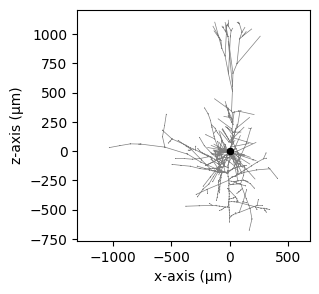

In [138]:
'''section coordinates based'''
dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\L5PC_Clone4_coordinates_sectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
section_coords = data['section_coords']
cell_section_names = section_coords['cell_section_names']
cell_section_coordinates_start = section_coords['cell_section_coordinates_start']
cell_section_coordinates_end = section_coords['cell_section_coordinates_end']
num_section = len(cell_section_names)
plot_coordinates = np.full((3, 3*num_section), np.nan)
for i in range(num_section):
    plot_coordinates[:, i*3] = cell_section_coordinates_start[i, :]
    plot_coordinates[:, i*3+1] = cell_section_coordinates_end[i, :]
# plot
fig = plt.figure(figsize=(3, 3))
ax  = fig.add_subplot(111)
ax.plot(plot_coordinates[0], plot_coordinates[2], color='gray', lw=0.5, zorder=-1) # x-z plane
soma_center = cell.get_section_center(cell.allSections[0])
ax.scatter(soma_center[0], soma_center[2], s=20, color='k', zorder=0)
ax.axis('equal')
# ax.axis('off')
ax.set_xlabel('x-axis (μm)', fontsize=10)
ax.set_ylabel('z-axis (μm)', fontsize=10)

Text(0, 0.5, 'z-axis (μm)')

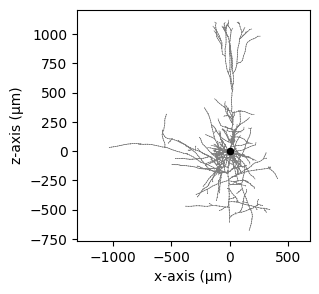

In [139]:
'''segment coordinates based'''
dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\L5PC_Clone4_coordinates_sectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
segment_coords = data['segment_coords']
cell_segment_names = segment_coords['cell_segment_names']
cell_segment_coordinates_start = segment_coords['cell_segment_coordinates_start']
cell_segment_coordinates_end = segment_coords['cell_segment_coordinates_end']
num_segment = len(cell_segment_names)
plot_coordinates = np.full((3, 3*num_segment), np.nan)
for i in range(num_segment):
    plot_coordinates[:, i*3] = cell_segment_coordinates_start[i, :]
    plot_coordinates[:, i*3+1] = cell_segment_coordinates_end[i, :]
# plot
fig = plt.figure(figsize=(3, 3))
ax  = fig.add_subplot(111)
ax.plot(plot_coordinates[0], plot_coordinates[2], color='gray', lw=0.5, zorder=-1) # x-z plane
soma_center = cell.get_section_center(cell.allSections[0])
ax.scatter(soma_center[0], soma_center[2], s=20, color='k', zorder=0)
ax.axis('equal')
# ax.axis('off')
ax.set_xlabel('x-axis (μm)', fontsize=10)
ax.set_ylabel('z-axis (μm)', fontsize=10)

# 3. Based on the surface information of the L5 soma after discretization, the cluster information of the L5 layer was obtained.

In [2]:
def getRotation_RotVecDegree(vec0, vec1):
    # 同Matlab中vrrotvec.m函数
    if type(vec0) == 'list':
        vec0 = np.array(vec0)
    if type(vec1) == 'list':
        vec1 = np.array(vec1)
    vec0_norm = vec0 / np.linalg.norm(vec0)
    vec1_norm = vec1 / np.linalg.norm(vec1)
    vecAx = np.cross(vec0, vec1)
    vecAx_norm = vecAx / np.linalg.norm(vecAx)
    angle = np.arccos(np.dot(vec0_norm, vec1_norm))
    return vecAx_norm, angle

def getRotationMatrix(vec0=None, vec1=None, vecAx=None, angle=None):
    # 同Matlab中vrrotvec2mat.m函数
    # https://en.wikipedia.org/wiki/Rotation_matrix
    if vecAx==None and angle==None:
        vecAx, angle = getRotation_RotVecDegree(vec0, vec1)
    if type(vecAx) == 'list':
        vecAx = np.array(vecAx)
    s = np.sin(angle)
    c = np.cos(angle)
    t = 1 - c
    vecAx = vecAx / np.linalg.norm(vecAx)
    x, y, z = vecAx 
    rotMatrix = np.array([[t*x*x + c,    t*x*y - s*z,  t*x*z + s*y], 
                          [t*x*y + s*z,  t*y*y + c,    t*y*z - s*x],
                          [t*x*z - s*y,  t*y*z + s*x,  t*z*z + c]])
    return rotMatrix

def CellPt3dchange_ByPhiNormalOrigin_NEURON(cellSectionLists, cell_phi, cell_normal, cell_origin):
    # 获得旋转矩阵
    rotMatrix_phi = getRotationMatrix(vecAx=[0, 0, 1], angle=cell_phi)
    rotMatrix_normal = getRotationMatrix(vec0=[0, 0, 1], vec1=cell_normal)
    for sec_hObj in cellSectionLists:
        for j in range(sec_hObj.n3d()):
            x0, y0, z0 = sec_hObj.x3d(j), sec_hObj.y3d(j), sec_hObj.z3d(j)
            vec_xyz = np.dot(rotMatrix_phi, np.array([x0, y0, z0]))
            vec_xyz = np.dot(rotMatrix_normal, vec_xyz)
            vec_xyz = vec_xyz + cell_origin
            sec_hObj.pt3dchange(j, vec_xyz[0], vec_xyz[1], vec_xyz[2], sec_hObj.diam3d(j))   

def placeCellSection_ByPhiNormalOrigin(secCoordStart, secCoordEnd, secCoordMid, cell_phi=None, cell_normal=None, cell_origin=None):
    # secCoordStart: shape is (numSection, 3=x,y,z)
    secCoordStart_new = np.zeros_like(secCoordStart)
    secCoordEnd_new   = np.zeros_like(secCoordEnd)
    secCoordMid_new   = np.zeros_like(secCoordMid)
    if cell_phi is None and cell_normal is None and cell_origin is None:
        print('Don\'t change cell coordinates.')
        return secCoordStart, secCoordEnd, secCoordMid
        
    if cell_phi is not None:
        rotMatrix_phi = getRotationMatrix(vecAx=[0, 0, 1], angle=cell_phi)
    if cell_normal is not None:
        rotMatrix_normal = getRotationMatrix(vec0=[0, 0, 1], vec1=cell_normal)
    for i in range(secCoordStart.shape[0]):
        xyz_start = secCoordStart[i, :]
        xyz_end   = secCoordEnd[i, :]
        xyz_mid   = secCoordMid[i, :]
        if cell_phi is not None:
            xyz_start = np.dot(rotMatrix_phi, xyz_start)
            xyz_end   = np.dot(rotMatrix_phi, xyz_end)
            xyz_mid   = np.dot(rotMatrix_phi, xyz_mid)
        if cell_normal is not None:
            xyz_start = np.dot(rotMatrix_normal, xyz_start)
            xyz_end   = np.dot(rotMatrix_normal, xyz_end)
            xyz_mid   = np.dot(rotMatrix_normal, xyz_mid)
        if cell_origin is not None:
            xyz_start += cell_origin
            xyz_end   += cell_origin
            xyz_mid   += cell_origin
        secCoordStart_new[i, :] = xyz_start
        secCoordEnd_new[i, :]   = xyz_end
        secCoordMid_new[i, :]   = xyz_mid

    return secCoordStart_new, secCoordEnd_new, secCoordMid_new

In [3]:
%%time
# (1) Load L5PC Clone4 section coordinates
dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\L5PC_Clone4_coordinates_sectionAndSegment.npy'
cellData = np.load(dataPath, allow_pickle=True).item()
print('cellData keys: ', cellData.keys())
'''section coordinates'''
section_coords = cellData['section_coords']
cell_section_names             = section_coords['cell_section_names']
cell_section_coordinates_start = section_coords['cell_section_coordinates_start'] * 1e-3 # unit: μm → mm
cell_section_coordinates_end   = section_coords['cell_section_coordinates_end'] * 1e-3   # unit: μm → mm
cell_section_coordinates_mid   = section_coords['cell_section_coordinates_mid'] * 1e-3   # unit: μm → mm
num_section                    = len(cell_section_names)
'''segment coordinates'''
segment_coords = cellData['segment_coords']
cell_segment_names             = segment_coords['cell_segment_names']
cell_segment_coordinates_start = segment_coords['cell_segment_coordinates_start'] * 1e-3 # unit: μm → mm
cell_segment_coordinates_end   = segment_coords['cell_segment_coordinates_end'] * 1e-3   # unit: μm → mm
cell_segment_coordinates_mid   = segment_coords['cell_segment_coordinates_mid'] * 1e-3   # unit: μm → mm
num_segment                    = len(cell_segment_names)

# (2) Load L5 SOI mesh information
dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_information_after_downsampling.npy'
surfData = np.load(dataPath, allow_pickle=True).item()
print('surfData keys: ', surfData.keys())
cell_normals = surfData['cell_normals']
cell_origins = surfData['cell_origins'] # unit is mm
num_element  = surfData['num_elem']

# (3) Rotate each cell around its normal vector, and then translate the origin.
'''section'''
popCells_section_coords   = {}
section_coordinates_start = np.zeros((num_element, num_section, 3))
section_coordinates_end   = np.zeros((num_element, num_section, 3))
section_coordinates_mid   = np.zeros((num_element, num_section, 3))
for i in range(num_element):
    cell_normal = cell_normals[i, :]
    cell_origin = cell_origins[i, :]
    secCoordStart, secCoordEnd, secCoordMid = placeCellSection_ByPhiNormalOrigin(cell_section_coordinates_start, cell_section_coordinates_end, \
                                 cell_section_coordinates_mid, cell_phi=None, cell_normal=cell_normal, cell_origin=cell_origin)
    section_coordinates_start[i, :, :] = secCoordStart
    section_coordinates_end[i, :, :]   = secCoordEnd
    section_coordinates_mid[i, :, :]   = secCoordMid
popCells_section_coords['section_coordinates_start'] = section_coordinates_start
popCells_section_coords['section_coordinates_end']   = section_coordinates_end
popCells_section_coords['section_coordinates_mid']   = section_coordinates_mid
'''segment'''
popCells_segment_coords   = {}
segment_coordinates_start = np.zeros((num_element, num_segment, 3))
segment_coordinates_end   = np.zeros((num_element, num_segment, 3))
segment_coordinates_mid   = np.zeros((num_element, num_segment, 3))
for i in range(num_element):
    cell_normal = cell_normals[i, :]
    cell_origin = cell_origins[i, :]
    segCoordStart, segCoordEnd, segCoordMid = placeCellSection_ByPhiNormalOrigin(cell_segment_coordinates_start, cell_segment_coordinates_end, \
                                 cell_segment_coordinates_mid, cell_phi=None, cell_normal=cell_normal, cell_origin=cell_origin)
    segment_coordinates_start[i, :, :] = segCoordStart
    segment_coordinates_end[i, :, :]   = segCoordEnd
    segment_coordinates_mid[i, :, :]   = segCoordMid
popCells_segment_coords['segment_coordinates_start'] = segment_coordinates_start
popCells_segment_coords['segment_coordinates_end']   = segment_coordinates_end
popCells_segment_coords['segment_coordinates_mid']   = segment_coordinates_mid

# (4) Save the location data of the Layer5 cluster, including the surface mesh data.
data = {
    'popCells_section_coords': popCells_section_coords,
    'popCells_segment_coords': popCells_segment_coords,
    'cell_normals': cell_normals,
    'cell_origins': cell_origins
}
savePath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popCelll_sectionAndSegmentCoordinates.npy'
if not os.path.exists(savePath):
    np.save(savePath, data)

cellData keys:  dict_keys(['section_coords', 'segment_coords'])
surfData keys:  dict_keys(['surface', 'vnormals', 'cell_normals', 'cell_origins', 'depth', 'num_elem'])
Wall time: 14.1 s


# 4. Find the n/10 elements that are closest to the given element

In [16]:
num_close = 10

dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_information_after_downsampling.npy'
surfData = np.load(dataPath, allow_pickle=True).item()
print('surfData keys: ', surfData.keys())
cell_normals = surfData['cell_normals']
cell_origins = surfData['cell_origins'] # unit is mm

point_givenBySnowp = np.array([-43.9248, -4.43097, 64.9797])
distance = cell_origins - point_givenBySnowp
distance = np.linalg.norm(distance, axis=1)
indeces_minNelement = np.argsort(distance)[:num_close]
print(indeces_minNelement)

surfData keys:  dict_keys(['surface', 'vnormals', 'cell_normals', 'cell_origins', 'depth', 'num_elem'])
[475 483 531 474 529 481 473 480 472 528]
